# Euclidean Alignment + Weighted TL

## Load dataset

In [1]:
import sys

In [2]:
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\plan_c\csp')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import moabb.datasets
import moabb.paradigms


from copy import deepcopy
from csp.utils import subject_counter
from csp.preprocess import fir_bandpass, apply_bandpass, fetch_left_right_EEG
from csp.preprocess import split_EEG_one_class, process_s_data
from csp.feat_extraction import compute_Z, feat_vector, true_label
from csp.csp import CSP

In [4]:
dframe = pd.DataFrame

In [5]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
ori_data = dict()
mod_data = dict() 

## Load Dataset

In [6]:
# Iter over all data path then store them in sub0X variable
for subj in range(1, 10):
    data_path = '../../datasets/BCICIV2a/A{:02d}T.npz'.format(subj)
    
    # Load EEG data from datapath and store into subj0X variabel then store into ori_dict
    # Then also fetch 's' (EEG data) into mod_data
    ori_data[subj] = np.load(data_path)
    mod_data[subj] = {}
    mod_data[subj]['s'] = deepcopy(ori_data[subj]['s'])
    mod_data[subj]['etyp'] = deepcopy(ori_data[subj]['etyp'])
    mod_data[subj]['epos'] = deepcopy(ori_data[subj]['epos'])
    
    # Remove last three EOG electrodes
    mod_data[subj]['s'] = np.delete(mod_data[subj]['s'], np.s_[22:], 1)

## Preprocessing

### Apply Bandpass Filter

In [7]:
from scipy.signal import firwin, freqs, lfilter

In [8]:
# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

In [9]:
## PREPROCESSING ##

# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

# Key to store result
EEG_filtered = 'EEG_filtered'

for subj in mod_data.keys():
    temp_raw_EEG = mod_data[subj]['s']
    
    mod_data[subj][EEG_filtered] = apply_bandpass(temp_raw_EEG, b)

### Fetch Left and Right Class

In [10]:
mod_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 'EEG_filtered'])

In [12]:
## Only fetch left and right class
mod_data = fetch_left_right_EEG(mod_data, ori_data=ori_data)
    
# Checking current size of EEG left and right data
print('\t\tLeft \t\t Right')

for subj in mod_data.keys():
    
    temp = mod_data[subj]
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['EEG_left'].shape, temp['EEG_right'].shape)) 

Processing for  1
Processing for  2
Processing for  3
Processing for  4
Processing for  5
Processing for  6
Processing for  7
Processing for  8
Processing for  9
		Left 		 Right
subject01:	(72, 22, 750)	(72, 22, 750)
subject02:	(72, 22, 750)	(72, 22, 750)
subject03:	(72, 22, 750)	(72, 22, 750)
subject04:	(72, 22, 750)	(72, 22, 750)
subject05:	(72, 22, 750)	(72, 22, 750)
subject06:	(72, 22, 750)	(72, 22, 750)
subject07:	(72, 22, 750)	(72, 22, 750)
subject08:	(72, 22, 750)	(72, 22, 750)
subject09:	(72, 22, 750)	(72, 22, 750)


In [17]:
# NEWLY ADDED FUNCTION PRCESS samples x chann of EEG FILTERED -> trials x samples x channel
for subj in mod_data.keys():
    process_s_data(mod_data[subj])
    print(mod_data[subj]['all_trials'].shape)

(144, 750, 22)
(144, 750, 22)
(144, 750, 22)
(144, 750, 22)
(144, 750, 22)
(144, 750, 22)
(144, 750, 22)
(144, 750, 22)
(144, 750, 22)


In [22]:
mod_data[1]['y']

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0.])

## Apply Data Alignment on raw EEG

In [23]:
# Import necessary library
from scipy.linalg import sqrtm, inv 

def apply_EA(data, key_list):
    '''
    Apply Euclidean aligment on array-like objects for 1 subject
    
    PARAMETER:
    data:
    dictionary data of one subject.
    dictionary containing left and right EEG data of each subject
    
    key_list:
    keys inside dict in which data that is about to be aligned are stored
    
    OUTPUT:
    dictionary data with aligned version of key_list
    '''
    
    # Concatenate left and right class
    left_key = [key for key in key_list if 'left' in key]
    right_key = [key for key in key_list if 'right' in key]
    
    left_trial = data[left_key[0]]
    right_trial = data[right_key[0]]
    
    # Concate both left and right trial
    all_trials = np.concatenate([left_trial, right_trial], axis=0)

    # Calculate reference matrix
    RefEA = 0

    # Iterate over all trials, compute reference EA
    for trial in all_trials:
        cov = np.cov(trial, rowvar=True)
        RefEA += cov

    # Average over all trials
    RefEA = RefEA/all_trials.shape[0]

    # Add to data
    data['RefEA'] = RefEA 
    
    # Compute R^(-0.5)
    R_inv = sqrtm(inv(RefEA))

    # Perform alignment on each trial
    X_EA_left = []
    X_EA_right = []
    
    for left, right in zip(left_trial, right_trial):
        X_EA_left.append(R_inv@left)
        X_EA_right.append(R_inv@right)

    # Store as left_EA and right_EA
    print('Adding EA_left and EA_right key ')
    data['EEG_left_EA'] = np.array(X_EA_left)
    data['EEG_right_EA'] = np.array(X_EA_right)

In [24]:
# Iterate over all subjects to compute the aligned EEG trials
# Define keys to be processed
process_key = ['EEG_left', 'EEG_right']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    apply_EA(mod_data[subj], process_key)
    print('')

Processing subject  1
Adding EA_left and EA_right key 

Processing subject  2
Adding EA_left and EA_right key 

Processing subject  3
Adding EA_left and EA_right key 

Processing subject  4
Adding EA_left and EA_right key 

Processing subject  5
Adding EA_left and EA_right key 

Processing subject  6
Adding EA_left and EA_right key 

Processing subject  7
Adding EA_left and EA_right key 

Processing subject  8
Adding EA_left and EA_right key 

Processing subject  9
Adding EA_left and EA_right key 



In [17]:
dframe(mod_data[3]['RefEA'])

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,25.650872,23.801770,25.398874,25.969270,25.502569,24.422906,19.415399,22.233508,24.068148,24.978227,...,21.427256,20.954147,22.368313,22.995651,22.929910,22.174650,20.525057,21.372880,21.020488,19.286099
1,23.801770,27.150986,26.371489,25.228500,23.802053,22.853112,22.410394,26.478632,26.046298,25.150637,...,20.105167,24.662392,24.560350,23.922925,23.004374,21.853748,22.627830,22.651384,21.776484,20.669979
2,25.398874,26.371489,27.433290,26.801438,25.802470,24.355214,21.774037,25.934938,26.985381,26.826847,...,21.532928,24.657343,25.605606,25.475202,24.800236,23.546719,23.584205,24.065762,23.291589,21.773354
3,25.969270,25.228500,26.801438,27.659533,26.845201,25.791479,20.371825,24.371657,26.244570,27.521350,...,22.458781,23.524072,24.970348,25.987195,25.584203,24.493158,23.287790,24.273317,23.791855,21.863690
4,25.502569,23.802053,25.802470,26.845201,27.173689,26.567991,19.680616,23.040357,25.509831,27.048137,...,23.987477,22.726972,24.718662,26.050557,26.392743,25.843799,23.431771,24.796053,24.798946,22.553711
5,24.422906,22.853112,24.355214,25.791479,26.567991,27.610340,18.892039,22.009959,24.089112,26.005228,...,25.190896,21.831232,23.522433,25.314428,26.187733,26.387183,22.746103,24.292881,24.810188,22.382268
6,19.415399,22.410394,21.774037,20.371825,19.680616,18.892039,23.258347,24.073195,22.937882,21.233750,...,17.943893,23.587079,22.777436,21.359103,20.498379,19.568472,21.765392,21.251735,20.315664,20.068136
7,22.233508,26.478632,25.934938,24.371657,23.040357,22.009959,24.073195,29.212638,27.883544,25.958381,...,20.155267,28.691638,27.828163,26.361353,24.919333,23.444717,26.449487,25.959270,24.698896,24.087153
8,24.068148,26.046298,26.985381,26.244570,25.509831,24.089112,22.937882,27.883544,28.815175,28.195631,...,22.245355,28.146128,29.003899,28.720509,27.612704,25.985761,27.805455,28.188471,27.140014,25.935444
9,24.978227,25.150637,26.826847,27.521350,27.048137,26.005228,21.233750,25.958381,28.195631,29.700272,...,23.816806,26.644129,28.570753,30.095586,29.350508,27.849800,27.782214,29.099506,28.483307,26.528539


In [18]:
left_alg = mod_data[2]['EEG_left_EA']

In [19]:
left_alg.shape

(72, 22, 750)

In [20]:
summ = 0
for tr in left_alg:
    summ += np.cov(tr, rowvar=True)
    
I = summ/left_alg.shape[0]
I = pd.DataFrame(np.round(I))

In [21]:
I

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
1,-0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0
2,0.0,-0.0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
3,-0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0
4,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
5,0.0,-0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0
6,-0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,0.0,0.0,-0.0,...,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
7,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
8,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,1.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0


In [22]:
# Sanity check
for subj in mod_data.keys():
    summ = 0
    
    left_alg = mod_data[subj]['EEG_left_EA']
    right_alg = mod_data[subj]['EEG_right_EA']
    
    for tr in left_alg:
        summ += np.cov(tr, rowvar=True)
    
    I = summ/left_alg.shape[0]
    I = pd.DataFrame(np.round(I))
    
    # Sum up all matrix elements should equal to number of eeg channels, i.e. 22
    assert (I.sum().sum() == 22)
    print('Subject {} OK!'.format(subj))

Subject 1 OK!
Subject 2 OK!
Subject 3 OK!
Subject 4 OK!
Subject 5 OK!
Subject 6 OK!
Subject 7 OK!
Subject 8 OK!
Subject 9 OK!


## Visualize raw data with and without EA

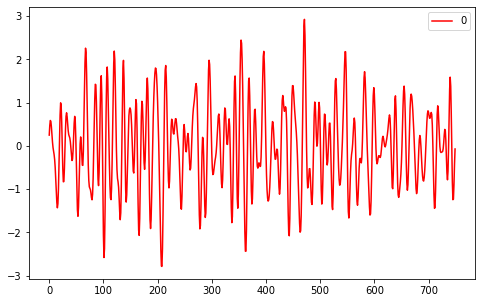

In [23]:
# let's try for one subject
fig, ax = plt.subplots(1, 1,  figsize=(8, 5))
n_alg = pd.DataFrame(mod_data[1]['EEG_left'][10][5])
alg = pd.DataFrame(mod_data[1]['EEG_left_EA'][10][5])

# n_alg.plot(ax=ax, color='k')
alg.plot(ax=ax, color='red')
plt.show()

In [24]:
def visualize_raw_and_aligned(data_dict, no_subj=1, no_trial=0, fs=250):
    '''
    Will plot the visualization of dictionary, left and right hand class
    
    Parameter:
    data_dict = data containing data of each subject
    '''
    left = data_dict[no_subj]['EEG_left'][no_trial]
    right = data_dict[no_subj]['EEG_right'][no_trial]
    left_alg = data_dict[no_subj]['EEG_left_EA'][no_trial]
    right_alg = data_dict[no_subj]['EEG_right_EA'][no_trial]
    
    # Time
    time = np.arange(left.shape[1])/fs
    
    # Number of electrodes
    n_el = left.shape[0]
    
    # Plot each raw EEG and aligned raw EEG
    fig, axes = plt.subplots(n_el, 2, figsize=(10, 15), sharex=True)
    
    # Title to each column
    axes[0, 0].set_title('Left')
    axes[0, 1].set_title('Right')

    # Plot each eeg raw and aligned 
    for i, ax in enumerate(axes):
        ax[0].plot(time, left[i], color='k', label='el ' + str(i))
        ax[0].plot(time, left_alg[i], color='r', label='el ' + str(i))
        ax[0].legend(loc=1)
        
        ax[1].plot(time, right[i], color='k', label='el ' + str(i))
        ax[1].plot(time, right_alg[i], color='r', label='el ' + str(i))
        ax[1].legend(loc=1)
    plt.show()

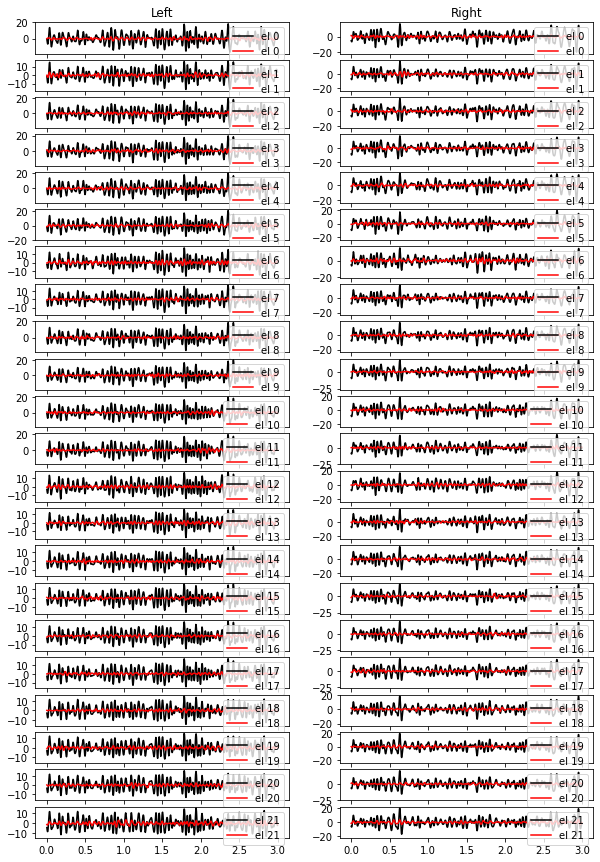

In [26]:
visualize_raw_and_aligned(mod_data, no_subj=2, no_trial=0, fs=250)

## Run CSP for both raw EEG and raw EEG aligned
Should test EEG raw be aligned?

In [27]:
## Split to train and test data
np.random.seed(42)
for subj in mod_data.keys():
    print('Processing split for', subj)
    
    mod_data[subj]['left_train'], mod_data[subj]['left_test'] = split_EEG_one_class(mod_data[subj]['EEG_left'], 0.8)
    mod_data[subj]['right_train'], mod_data[subj]['right_test'] = split_EEG_one_class(mod_data[subj]['EEG_right'], 0.8)     
 
    mod_data[subj]['left_train_EA'], mod_data[subj]['left_test_EA'] = split_EEG_one_class(mod_data[subj]['EEG_left_EA'], 0.8)
    mod_data[subj]['right_train_EA'], mod_data[subj]['right_test_EA'] = split_EEG_one_class(mod_data[subj]['EEG_right_EA'], 0.8)   

Processing split for 1
Processing split for 2
Processing split for 3
Processing split for 4
Processing split for 5
Processing split for 6
Processing split for 7
Processing split for 8
Processing split for 9


In [28]:
# Checking size of EEG left and right data training and test data
print("==================== Not Aligned ======================")
print('\t\tLeft \t\t Right')
print('TRAINING')
for subj in mod_data.keys():
    
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_train'].shape, temp['right_train'].shape))

print('TEST')
for subj in mod_data.keys():

    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_test'].shape, temp['right_test'].shape))

print("\n==================== Aligned ======================")
print('TRAINING')
for subj in mod_data.keys():
    
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_train_EA'].shape, temp['right_train_EA'].shape))

print('TEST')
for subj in mod_data.keys():

    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_test_EA'].shape, temp['right_test_EA'].shape))    


==================== Not Aligned ======================
		Left 		 Right
TRAINING
subject01:	(58, 22, 750)	(58, 22, 750)
subject02:	(58, 22, 750)	(58, 22, 750)
subject03:	(58, 22, 750)	(58, 22, 750)
subject04:	(58, 22, 750)	(58, 22, 750)
subject05:	(58, 22, 750)	(58, 22, 750)
subject06:	(58, 22, 750)	(58, 22, 750)
subject07:	(58, 22, 750)	(58, 22, 750)
subject08:	(58, 22, 750)	(58, 22, 750)
subject09:	(58, 22, 750)	(58, 22, 750)
TEST
subject01:	(14, 22, 750)	(14, 22, 750)
subject02:	(14, 22, 750)	(14, 22, 750)
subject03:	(14, 22, 750)	(14, 22, 750)
subject04:	(14, 22, 750)	(14, 22, 750)
subject05:	(14, 22, 750)	(14, 22, 750)
subject06:	(14, 22, 750)	(14, 22, 750)
subject07:	(14, 22, 750)	(14, 22, 750)
subject08:	(14, 22, 750)	(14, 22, 750)
subject09:	(14, 22, 750)	(14, 22, 750)

==================== Aligned ======================
TRAINING
subject01:	(58, 22, 750)	(58, 22, 750)
subject02:	(58, 22, 750)	(58, 22, 750)
subject03:	(58, 22, 750)	(58, 22, 750)
subject04:	(58, 22, 750)	(58, 22,

## CSP

### For Not Aligned

In [29]:
csp = CSP()

print("====================== Not Aligned Data =====================")
for subj in mod_data.keys():

    print('Computing cov for ', subj)
    print('---------------------------')
    
    mod_data[subj]['CSP'] = {}
    
    # Covariance
    print('Computing covariance of each class and composite covariance')
    mod_data[subj]['CSP']['cov_left'] = csp.compute_cov(mod_data[subj]['left_train'])
    mod_data[subj]['CSP']['cov_right'] = csp.compute_cov(mod_data[subj]['right_train'])
    mod_data[subj]['CSP']['cov_comp']  = mod_data[subj]['CSP']['cov_left'] + mod_data[subj]['CSP']['cov_right']
    
    # Whitening matrix
    print('Computing eigenval, eigenvec, and whitening matrix of composite covariance ')
    mod_data[subj]['CSP']['whitening'] = {}
    
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening = mod_data[subj]['CSP']['whitening']
    temp_cov = mod_data[subj]['CSP']['cov_comp']
    
    temp_whitening['eigval'], temp_whitening['eigvec'] = csp.decompose_cov(temp_cov)

    # White matrix
    temp_whitening['P'] = csp.white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])
    
    # Common eigenvec from Sl and Sr
    print('Generating common eigenvector from each class')
    mod_data[subj]['CSP']['S_left'] = {}
    mod_data[subj]['CSP']['S_right'] = {}  
    
    # Where to access data
    temp_P = mod_data[subj]['CSP']['whitening']['P']
    Cl = mod_data[subj]['CSP']['cov_left']
    Cr = mod_data[subj]['CSP']['cov_right']
    
    # Where to store result
    temp_Sl = mod_data[subj]['CSP']['S_left']
    temp_Sr = mod_data[subj]['CSP']['S_right']

    # LEFT
    Sl = csp.compute_S(Cl, temp_P)
    temp_Sl['eigvec'], temp_Sl['eigval'] = csp.decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = csp.compute_S(Cr, temp_P)
    temp_Sr['eigvec'], temp_Sr['eigval'] = csp.decompose_S(Sr, 'ascending')   
    
    # Spatial filter
    print('Spatial filter for ',subj)
    temp_eigvec = mod_data[subj]['CSP']['S_left']['eigvec']
    temp_P = mod_data[subj]['CSP']['whitening']['P']
    
    mod_data[subj]['CSP']['W'] = csp.spatial_filter(temp_eigvec, temp_P)
    
    print(' ')

====================== Not Aligned Data =====================
Computing cov for  1
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  1
 
Computing cov for  2
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  2
 
Computing cov for  3
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  3
 
Computing cov for  4
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite 

### Aligned Data

In [30]:
csp = CSP()

print("====================== Aligned Data =====================")
for subj in mod_data.keys():

    print('Computing cov for ', subj)
    print('---------------------------')
    
    mod_data[subj]['CSP_EA'] = {}
    
    # Covariance
    print('Computing covariance of each class and composite covariance')
    mod_data[subj]['CSP_EA']['cov_left'] = csp.compute_cov(mod_data[subj]['EEG_left_EA'])
    mod_data[subj]['CSP_EA']['cov_right'] = csp.compute_cov(mod_data[subj]['EEG_right_EA'])
    mod_data[subj]['CSP_EA']['cov_comp']  = mod_data[subj]['CSP_EA']['cov_left'] + mod_data[subj]['CSP_EA']['cov_right']
    
    # Whitening matrix
    print('Computing eigenval, eigenvec, and whitening matrix of composite covariance ')
    mod_data[subj]['CSP_EA']['whitening'] = {}
    
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening = mod_data[subj]['CSP_EA']['whitening']
    temp_cov = mod_data[subj]['CSP_EA']['cov_comp']
    
    temp_whitening['eigval'], temp_whitening['eigvec'] = csp.decompose_cov(temp_cov)

    # White matrix
    temp_whitening['P'] = csp.white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])
    
    # Common eigenvec from Sl and Sr
    print('Generating common eigenvector from each class')
    mod_data[subj]['CSP_EA']['S_left'] = {}
    mod_data[subj]['CSP_EA']['S_right'] = {}  
    
    # Where to access data
    temp_P = mod_data[subj]['CSP_EA']['whitening']['P']
    Cl = mod_data[subj]['CSP_EA']['cov_left']
    Cr = mod_data[subj]['CSP_EA']['cov_right']
    
    # Where to store result
    temp_Sl = mod_data[subj]['CSP_EA']['S_left']
    temp_Sr = mod_data[subj]['CSP_EA']['S_right']

    # LEFT
    Sl = csp.compute_S(Cl, temp_P)
    temp_Sl['eigvec'], temp_Sl['eigval'] = csp.decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = csp.compute_S(Cr, temp_P)
    temp_Sr['eigvec'], temp_Sr['eigval'] = csp.decompose_S(Sr, 'ascending')   
    
    # Spatial filter
    print('Spatial filter for ',subj)
    temp_eigvec = mod_data[subj]['CSP_EA']['S_left']['eigvec']
    temp_P = mod_data[subj]['CSP_EA']['whitening']['P']
    
    mod_data[subj]['CSP_EA']['W'] = csp.spatial_filter(temp_eigvec, temp_P)
    
    print(' ')

====================== Aligned Data =====================
Computing cov for  1
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  1
 
Computing cov for  2
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  2
 
Computing cov for  3
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  3
 
Computing cov for  4
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite cova

## Train Feature

### Not Aligned Data

In [31]:
# Select number of filter
m = 2

# Seed to fix randomization
np.random.seed(42)

print('============ Not Aligned ===============')
# Create new keys for trainning and test feature vector
for subj in mod_data.keys():
    
    print('Generating training vector for ', subj)
    
    mod_data[subj]['train']= {}  

    temp_W = mod_data[subj]['CSP']['W']
    temp_EEG_left = mod_data[subj]['left_train']
    temp_EEG_right = mod_data[subj]['right_train']
    
    # LEFT
    mod_data[subj]['train']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['train']['feat_left'] = feat_vector(mod_data[subj]['train']['Z_left'])
    left_label = true_label(mod_data[subj]['train']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['train']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['train']['feat_right'] = feat_vector(mod_data[subj]['train']['Z_right'])     
    right_label = true_label(mod_data[subj]['train']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['train']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['train']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['train']['feat_train'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['train']['feat_train'])
    
    print('Training dataset shape {}\n'.format(mod_data[subj]['train']['feat_train'].shape))

============ Not Aligned ===============
Generating training vector for  1
Training dataset shape (116, 5)

Generating training vector for  2
Training dataset shape (116, 5)

Generating training vector for  3
Training dataset shape (116, 5)

Generating training vector for  4
Training dataset shape (116, 5)

Generating training vector for  5
Training dataset shape (116, 5)

Generating training vector for  6
Training dataset shape (116, 5)

Generating training vector for  7
Training dataset shape (116, 5)

Generating training vector for  8
Training dataset shape (116, 5)

Generating training vector for  9
Training dataset shape (116, 5)



In [32]:
mod_data[1]['train']['feat_train'][:5]

array([[-0.80850967, -0.6600156 , -0.48623359, -0.52374037,  1.        ],
       [-0.40809937, -0.50156184, -0.85628869, -0.80985649,  0.        ],
       [-0.45061195, -0.53515375, -0.78251033, -0.72343572,  0.        ],
       [-0.62933009, -0.5755371 , -0.46896779, -0.79636582,  0.        ],
       [-0.7143548 , -0.53946605, -0.52948956, -0.65221154,  0.        ]])

### Aligned Data

In [33]:
# Select number of filter
m = 2

# Seed to fix randomization
np.random.seed(42)

print('============ Aligned ===============')
# Create new keys for trainning and test feature vector
for subj in mod_data.keys():
    
    print('Generating training vector for ', subj)
    
    mod_data[subj]['train_EA']= {}  

    temp_W = mod_data[subj]['CSP_EA']['W']
    temp_EEG_left = mod_data[subj]['left_train_EA']
    temp_EEG_right = mod_data[subj]['right_train_EA']
    
    # LEFT
    mod_data[subj]['train_EA']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['train_EA']['feat_left'] = feat_vector(mod_data[subj]['train_EA']['Z_left'])
    left_label = true_label(mod_data[subj]['train_EA']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['train_EA']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['train_EA']['feat_right'] = feat_vector(mod_data[subj]['train_EA']['Z_right'])     
    right_label = true_label(mod_data[subj]['train_EA']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['train_EA']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['train_EA']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['train_EA']['feat_train'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['train_EA']['feat_train'])
    
    print('Training dataset shape {}\n'.format(mod_data[subj]['train_EA']['feat_train'].shape))

============ Aligned ===============
Generating training vector for  1
Training dataset shape (116, 5)

Generating training vector for  2
Training dataset shape (116, 5)

Generating training vector for  3
Training dataset shape (116, 5)

Generating training vector for  4
Training dataset shape (116, 5)

Generating training vector for  5
Training dataset shape (116, 5)

Generating training vector for  6
Training dataset shape (116, 5)

Generating training vector for  7
Training dataset shape (116, 5)

Generating training vector for  8
Training dataset shape (116, 5)

Generating training vector for  9
Training dataset shape (116, 5)



## Test Feature

### For Not Aligned

In [34]:
# Create new keys for test feature vector
np.random.seed(42)

for subj in mod_data.keys():
    
    print('Generating test vector for ', subj)
    
    mod_data[subj]['test']= {}  

    temp_W = mod_data[subj]['CSP']['W']
    temp_EEG_left = mod_data[subj]['left_test']
    temp_EEG_right = mod_data[subj]['right_test']
      
    # LEFT
    mod_data[subj]['test']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['test']['feat_left'] = feat_vector(mod_data[subj]['test']['Z_left'])
    left_label = true_label(mod_data[subj]['test']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['test']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['test']['feat_right'] = feat_vector(mod_data[subj]['test']['Z_right'])     
    right_label = true_label(mod_data[subj]['test']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['test']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['test']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['test']['feat_test'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['test']['feat_test'])
    
    print('Test dataset shape {}\n'.format(mod_data[subj]['test']['feat_test'].shape))

Generating test vector for  1
Test dataset shape (28, 5)

Generating test vector for  2
Test dataset shape (28, 5)

Generating test vector for  3
Test dataset shape (28, 5)

Generating test vector for  4
Test dataset shape (28, 5)

Generating test vector for  5
Test dataset shape (28, 5)

Generating test vector for  6
Test dataset shape (28, 5)

Generating test vector for  7
Test dataset shape (28, 5)

Generating test vector for  8
Test dataset shape (28, 5)

Generating test vector for  9
Test dataset shape (28, 5)



In [35]:
mod_data[1]['test']['feat_test'][:5]

array([[-0.54764994, -0.52291841, -0.59991892, -0.78140058,  0.        ],
       [-0.78563928, -0.50154629, -0.4974035 , -0.69260143,  1.        ],
       [-0.50800975, -0.44099642, -0.73292701, -0.84665142,  0.        ],
       [-0.69895462, -0.65752097, -0.50560207, -0.57220645,  1.        ],
       [-0.42377025, -0.5038312 , -0.81735151, -0.80309321,  0.        ]])

### For Aligned

In [36]:
# Create new keys for test feature vector
np.random.seed(42)

for subj in mod_data.keys():
    
    print('Generating test vector for ', subj)
    
    mod_data[subj]['test_EA']= {}  

    temp_W = mod_data[subj]['CSP_EA']['W']
    temp_EEG_left = mod_data[subj]['left_test_EA']
    temp_EEG_right = mod_data[subj]['right_test_EA']
      
    # LEFT
    mod_data[subj]['test_EA']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['test_EA']['feat_left'] = feat_vector(mod_data[subj]['test_EA']['Z_left'])
    left_label = true_label(mod_data[subj]['test_EA']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['test_EA']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['test_EA']['feat_right'] = feat_vector(mod_data[subj]['test_EA']['Z_right'])     
    right_label = true_label(mod_data[subj]['test_EA']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['test_EA']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['test_EA']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['test_EA']['feat_test'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['test_EA']['feat_test'])
    
    print('Test dataset shape {}\n'.format(mod_data[subj]['test_EA']['feat_test'].shape))

Generating test vector for  1
Test dataset shape (28, 5)

Generating test vector for  2
Test dataset shape (28, 5)

Generating test vector for  3
Test dataset shape (28, 5)

Generating test vector for  4
Test dataset shape (28, 5)

Generating test vector for  5
Test dataset shape (28, 5)

Generating test vector for  6
Test dataset shape (28, 5)

Generating test vector for  7
Test dataset shape (28, 5)

Generating test vector for  8
Test dataset shape (28, 5)

Generating test vector for  9
Test dataset shape (28, 5)



In [63]:
mod_data[1]['EEG_left'].shape

(72, 22, 750)

## CSP algorithm ver 2 (MATLAB)
This CSP algorithm is adopted from the TLBCI MATLAB code. Used this code to process EEG data and output feature,   
ver2 computes each left and right separately,  
ver3 computes all trials at once

In [237]:
import numpy.linalg as la

def csp_feat_ver2(data, no_subj=1, n_filter=3):
    '''
    Adaptation of MATLAB csp code in python, the original work is called TLBCI 
    
    Parameter:
    data: dictionary containing data of each subject EEG signal, y class
    '''
    
    n_chan = data[no_subj]['EEG_left'].shape[1]
    
    EEG_left = data[no_subj]['EEG_left']
    EEG_right = data[no_subj]['EEG_right']
    
    # Covariance of left and right
    cov_left = 0
    for signal in range(EEG_left.shape[0]):
        cov_left += np.cov(signal, rowvar=True, ddof=0)
    
    cov_left = cov_left/EEG_left.shape[0]
    
    cov_right = 0
    for signal in range(EEG_right.shape[0]):
        cov_right += np.cov(signal, rowvar=True, ddof=0)

    cov_left = cov_right/EEG_right.shape[0]

    mldiv = la.lstsq(cov_right, cov_left)
    
    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)
    
    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]
    
    # W matrix
    eigvec = np.delete(eigvec, np.s_[n_filt::-n_filt], axis=1)
    
    # Calculating feature train 
    feat_left = []
    for trial in range(EEG_left.shape[0]):
        X = W.T@trial
        feat_left = np.log10(np.diag(X@X.T)/np.trace(X@X.T))
    
    feat_right = []
    for trial in range(EEG_right.shape[0]):
        X = W.T@trial
        feat_right = np.log10(np.diag(X@X.T)/np.trace(X@X.T))
        
    feat_left = np.array(feat_left)
    feat_right = np.array(feat_right)

In [ ]:
import numpy.linalg as la

def csp_feat_ver3(data, no_subj=1, n_filter=3):
    '''
    Adaptation of MATLAB csp code in python, the original work is called TLBCI 
    
    Parameter:
    data: dictionary containing data of each subject EEG signal, y class
    '''
    
    n_chan = data[no_subj]['EEG_raw']
    
    X
    X_right = 
    
    # Covariance of left and right
    cov_left = 0
    for signal in range(EEG_left.shape[0]):
        cov_left += np.cov(signal, rowvar=True, ddof=0)
    
    cov_left = cov_left/EEG_left.shape[0]
    
    cov_right = 0
    for signal in range(EEG_right.shape[0]):
        cov_right += np.cov(signal, rowvar=True, ddof=0)

    cov_left = cov_right/EEG_right.shape[0]

    mldiv = la.lstsq(cov_right, cov_left)
    
    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)
    
    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]
    
    # W matrix
    eigvec = np.delete(eigvec, np.s_[n_filt::-n_filt], axis=1)
    
    # Calculating feature train 
    feat_left = []
    for trial in range(EEG_left.shape[0]):
        X = W.T@trial
        feat_left = np.log10(np.diag(X@X.T)/np.trace(X@X.T))
    
    feat_right = []
    for trial in range(EEG_right.shape[0]):
        X = W.T@trial
        feat_right = np.log10(np.diag(X@X.T)/np.trace(X@X.T))
        
    feat_left = np.array(feat_left)
    feat_right = np.array(feat_right)

## Load data processed in MATLAB
The following features are computed using CSP algorihtm on matlab, the TLBCI reference code

In [275]:
import scipy.io as sio

In [276]:
dat = sio.loadmat('csp_all_feat.mat')

In [277]:
dat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'XEA1', 'XEA2', 'XEA3', 'XEA4', 'XEA5', 'XEA6', 'XEA7', 'XEA8', 'XEA9', 'ans', 'data', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6', 'feat7', 'feat8', 'feat9', 'featEA1', 'featEA2', 'featEA3', 'featEA4', 'featEA5', 'featEA6', 'featEA7', 'featEA8', 'featEA9', 'fs', 'i', 'j', 'meas', 'refEA', 'species', 'sqrtRefEA', 'y'])

In [282]:
feat ={}
featEA = {}

feat['no_sne'] = {}
feat['sne'] = {}

featEA['no_sne'] = {}
featEA['sne'] = {}

for i in range(1, 10):
    key = 'feat' + str(i)
    key_ea = 'featEA' + str(i)
    
    # Copying
    print('Processing {} and {}'.format(key, key_ea))
    feat['no_sne'][i] = deepcopy(dat[key])
    featEA['no_sne'][i] = deepcopy(dat[key_ea])

Processing feat1 and featEA1
Processing feat2 and featEA2
Processing feat3 and featEA3
Processing feat4 and featEA4
Processing feat5 and featEA5
Processing feat6 and featEA6
Processing feat7 and featEA7
Processing feat8 and featEA8
Processing feat9 and featEA9


In [320]:
for i in range(1, 10):
    print('Processing {} and {}'.format(key, key_ea))
    feat['sne'][i] = TSNE(n_iter=2000).fit_transform(feat['no_sne'][i])
    featEA['sne'][i] = TSNE(n_iter=2000).fit_transform(featEA['no_sne'][i])

Processing no_sne and no_sne
Processing no_sne and no_sne
Processing no_sne and no_sne
Processing no_sne and no_sne
Processing no_sne and no_sne
Processing no_sne and no_sne
Processing no_sne and no_sne
Processing no_sne and no_sne
Processing no_sne and no_sne


In [301]:
dframe(feat['sne'][1][:5])

,0,1
0,-4.964461,1.295299
1,9.162988,-13.662567
2,9.458892,-12.889444
3,-2.446877,0.608885
4,-4.566401,1.988885


In [300]:
dframe(featEA['sne'][1][:5])

,0,1
0,-4.372869,3.548180
1,7.471274,-11.887501
2,6.579980,-11.779330
3,-0.517304,5.293356
4,-4.043311,4.825746


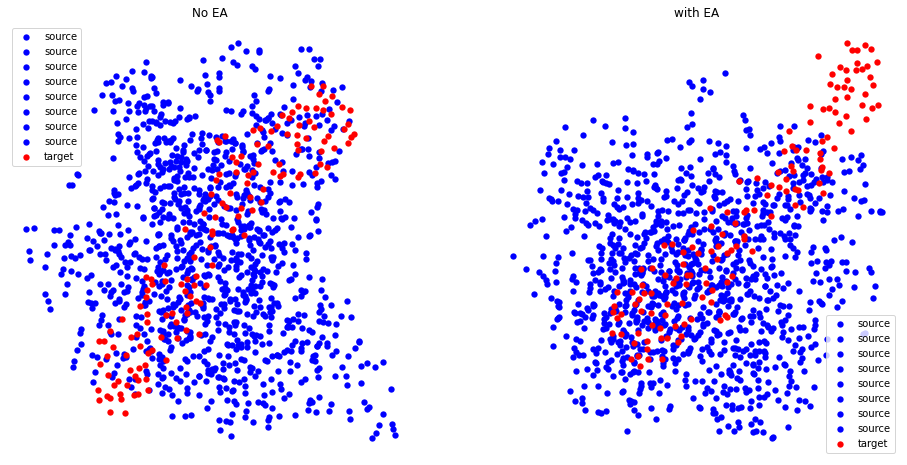

In [321]:
# Let's set the subject 1 as target
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

colorlist = {
    'tgt' : 'red',
    'src' : 'blue'
}

for i in np.unique(list_subj):
    ax0.set_title('No EA')
    tgt_subj = 9
    if i == tgt_subj:
        ax0.scatter(feat['sne'][i][:, 0], feat['sne'][i][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax0.scatter(feat['sne'][i][:, 0], feat['sne'][i][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    if i == tgt_subj:
        ax1.scatter(featEA['sne'][i][:, 0], featEA['sne'][i][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax1.scatter(featEA['sne'][i][:, 0], featEA['sne'][i][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')


In [307]:
import seaborn as sns
palette = np.array(sns.color_palette(n_colors=10))
palette

array([[0.12156863, 0.46666667, 0.70588235],
       [1.        , 0.49803922, 0.05490196],
       [0.17254902, 0.62745098, 0.17254902],
       [0.83921569, 0.15294118, 0.15686275],
       [0.58039216, 0.40392157, 0.74117647],
       [0.54901961, 0.3372549 , 0.29411765],
       [0.89019608, 0.46666667, 0.76078431],
       [0.49803922, 0.49803922, 0.49803922],
       [0.7372549 , 0.74117647, 0.13333333],
       [0.09019608, 0.74509804, 0.81176471]])

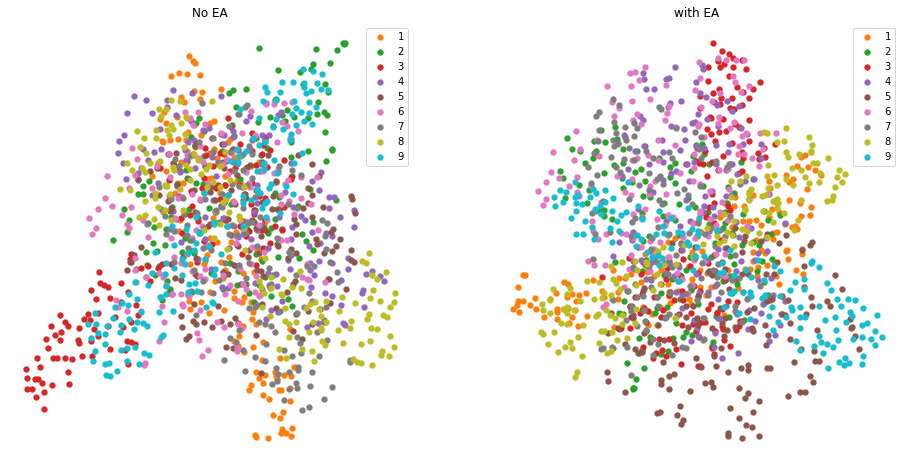

In [309]:
# Distribution of all subjects
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

for i in np.unique(list_subj):
    ax0.set_title('No EA')
    ax0.scatter(feat['sne'][i][:, 0], feat['sne'][i][:, 1], lw=0, s=40, color=palette[i], label=i)
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    ax1.scatter(featEA['sne'][i][:, 0], featEA['sne'][i][:, 1], lw=0, s=40, color=palette[i], label=i)
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

### Is CSP feat from aligned raw equal to Identity?

In [37]:
# Pick one feature from any subject
all_feats = mod_data[6]['train']['feat_train'][:, :-1]

# all_feats.shape
summ=0

cov = np.cov(all_feats, rowvar=False)
dframe(np.round(cov, 3))
# for tr in all_feats:
#     tr = tr[:, None]
#     summ += np.cov(tr, rowvar=True)
    
# I = summ/all_feats.shape[0]
#     I = pd.DataFrame(np.round(I, 2))
    
# I

,0,1,2,3
0,0.020,0.005,-0.003,-0.017
1,0.005,0.015,-0.006,-0.009
2,-0.003,-0.006,0.017,-0.005
3,-0.017,-0.009,-0.005,0.025


In [38]:
# Pick one feature from any subject
all_feats = mod_data[6]['train_EA']['feat_train'][:, :-1]

# all_feats.shape
summ=0

cov = np.cov(all_feats, rowvar=False)
dframe(np.round(cov, 3))

,0,1,2,3
0,0.017,0.005,-0.013,-0.004
1,0.005,0.014,-0.006,-0.009
2,-0.013,-0.006,0.016,-0.001
3,-0.004,-0.009,-0.001,0.017


In [188]:
print('EA')
print(mod_data[3]['train_EA']['feat_train'][:5])
print('\nWithout EA')
print(mod_data[3]['train']['feat_train'][:5])

EA
[[-0.75182574 -0.39807597 -0.5054261  -0.95568805  0.        ]
 [-0.89934298 -0.77894611 -0.55118382 -0.3700974   1.        ]
 [-0.43089979 -0.42675126 -0.79358871 -1.02658377  0.        ]
 [-0.86055451 -0.61511053 -0.61929478 -0.42105687  1.        ]
 [-0.86785029 -0.86111558 -0.58420075 -0.33137639  1.        ]]

Without EA
[[-0.79960813 -0.48624761 -0.38812275 -0.97542846  0.        ]
 [-0.93080063 -0.77671655 -0.53787908 -0.37090305  1.        ]
 [-0.44180752 -0.43462289 -0.76572406 -1.00294624  0.        ]
 [-0.88705968 -0.60760113 -0.64073071 -0.40365836  1.        ]
 [-0.88836481 -0.84354411 -0.62583333 -0.30923962  1.        ]]


### Comparing feature distribution of not-aligned vs aligned raw EEG

In [39]:
from sklearn.manifold import TSNE

In [40]:
X_EA = np.array([])
X = np.array([])

list_subj = []

for subj in mod_data.keys():
    print('Processing subject: ', subj)
    feat_EA = mod_data[subj]['train_EA']['feat_train'][:, :-1]
    feat = mod_data[subj]['train']['feat_train'][:, :-1]

    if (len(X) == 0) or (len(X_EA) == 0):
        X = feat
        X_EA = feat_EA
    else:
        X = np.vstack([X, feat])
        X_EA = np.vstack([X_EA, feat])
        
    list_subj.append([subj]*len(feat))
    
list_subj = np.array(list_subj).ravel()
X_sne = TSNE(n_iter=1000).fit_transform(X)
X_sne_EA = TSNE(n_iter=1000).fit_transform(X_EA)

Processing subject:  1
Processing subject:  2
Processing subject:  3
Processing subject:  4
Processing subject:  5
Processing subject:  6
Processing subject:  7
Processing subject:  8
Processing subject:  9


In [41]:
print(X_sne.shape)
print(X_sne_EA.shape)

(1044, 2)
(1044, 2)


In [42]:
# Define palette
import seaborn as sns

In [43]:
palette = np.array(sns.color_palette(palette='bright', n_colors=10))

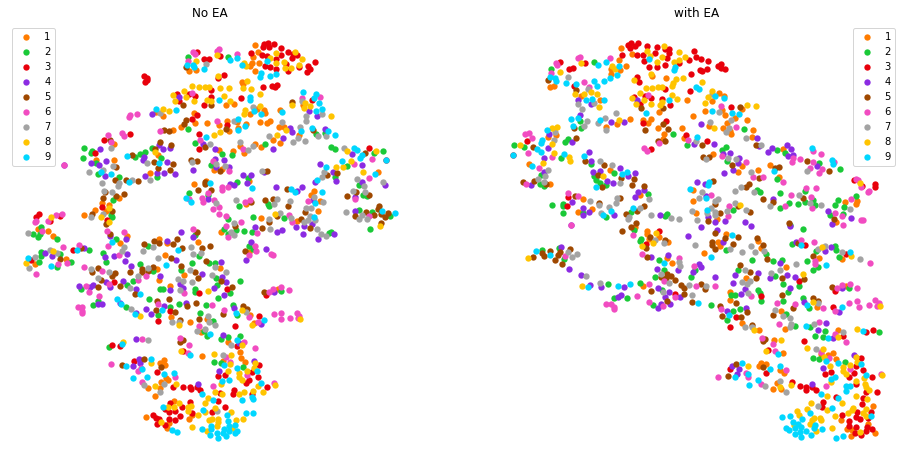

In [122]:
# Distribution of all subjects
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

for i in np.unique(list_subj):
    ax0.set_title('No EA')
    ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=palette[i], label=i)
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=palette[i], label=i)
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

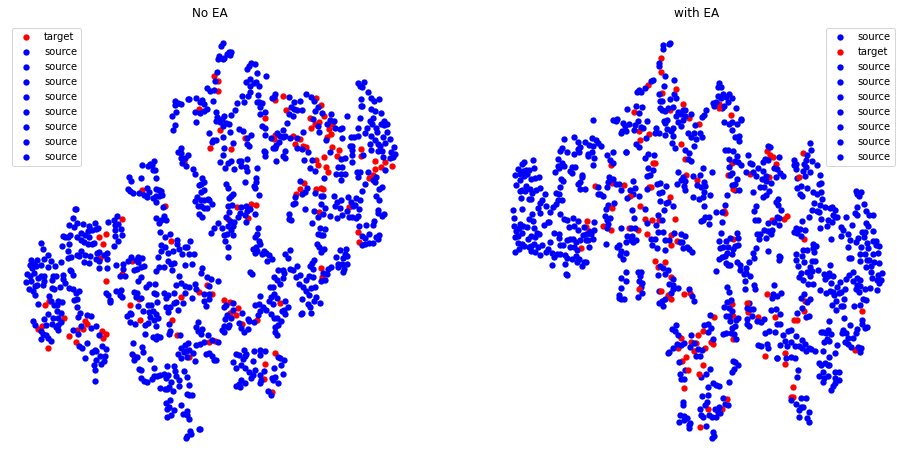

In [265]:
# Let's set the subject 1 as target
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

colorlist = {
    'tgt' : 'red',
    'src' : 'blue'
}

for i in np.unique(list_subj):
    ax0.set_title('No EA')
    if i == 1:
        ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    if i == 2:
        ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

### See if all raw_EEG_EA covariance add up to identity matrix

In [158]:
both = np.concatenate([left, right], axis=0)

In [159]:
both.shape

(144, 22, 750)

In [160]:
all_trials = np.array([])
all_trials_EA = np.array([])

if (len(all_trials) and len(all_trials_EA)) == 0:
    print('aa')
else:
    print('b')

aa


In [161]:
len(all_trials_EA)

0

In [162]:
# Stack all trials of left and right of all subjects
all_trials = np.array([])
all_trials_EA = np.array([])

for subj in mod_data.keys():
    # left and right of each subject
    left = mod_data[subj]['EEG_left']
    right = mod_data[subj]['EEG_right']
    
    left_EA = mod_data[subj]['EEG_left_EA']
    right_EA = mod_data[subj]['EEG_right_EA']
    
    # Stack them together
    both = np.concatenate([left, right], axis=0)
    both_EA = np.concatenate([left_EA, right_EA], axis=0)
    
    # Add to all_trials
    if ((len(all_trials)) or (len(all_trials_EA))) == 0:
        print('creating stack...')
        all_trials = both
        all_trials_EA = both_EA
    else:
        print('adding stack...')
        all_trials = np.concatenate([all_trials, both], axis=0)
        all_trials_EA = np.concatenate([all_trials_EA, both_EA], axis=0)

        
print('In total all trials non-EA in shape of: ', all_trials.shape)
print('In total all trials EA in shape of: ', all_trials_EA.shape)

creating stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
In total all trials non-EA in shape of:  (1296, 22, 750)
In total all trials EA in shape of:  (1296, 22, 750)


In [164]:
# Covariance of all trial
summ == 0
count = 0 
for t in all_trials_EA:
    count += 1
    cov = np.cov(t, rowvar=True, ddof=0)
    summ += cov
    
print(count)
summ = summ/all_trials_EA.shape[0]
dframe(np.round(summ))

1296


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
trials = np.concatenate([left, right, right2], axis=0)

216


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,-0.0,1.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0
2,0.0,-0.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
3,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0
5,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
6,-0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,1.0,-0.0,0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0
8,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0,...,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
9,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0


In [290]:
X.shape

(1044, 4)

In [291]:
len(list_subj)

9

In [307]:
list_subj[116:232]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

In [285]:
list_subj=[]

In [286]:
list_subj.append([1]*len(feat))

In [293]:
len(list_subj)

9

In [296]:
aaa = np.array(list_subj).ravel()

In [298]:
aaa

(1044,)

In [246]:
del aa

In [249]:
aa = np.array([])

In [258]:
if len(aa) == 0:
    aa = b
else:
    aa = np.concatenate([aa, b])

In [259]:
aa

array([[4, 2, 4],
       [4, 3, 2],
       [1, 2, 3],
       [4, 2, 4],
       [4, 3, 2],
       [1, 2, 3],
       [4, 2, 4],
       [4, 3, 2],
       [1, 2, 3]])

In [252]:
b = np.random.randint(1, 5, 9).reshape(3, 3)

In [253]:
b

array([[4, 2, 4],
       [4, 3, 2],
       [1, 2, 3]])

In [37]:
cek = mod_data[1]['train']['feat_train'][:, :-1]
cek.shape

(116, 4)

In [44]:
dframe(cek)

,0,1,2,3
0,-0.808510,-0.660016,-0.486234,-0.523740
1,-0.408099,-0.501562,-0.856289,-0.809856
2,-0.450612,-0.535154,-0.782510,-0.723436
3,-0.629330,-0.575537,-0.468968,-0.796366
4,-0.714355,-0.539466,-0.529490,-0.652212
...,...,...,...,...
111,-0.845827,-0.680004,-0.506660,-0.472319
112,-0.623381,-0.686391,-0.549838,-0.562002
113,-0.887604,-0.768211,-0.487944,-0.426191
114,-0.436771,-0.551932,-0.689931,-0.825595


In [40]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1)

In [48]:
new_cek = tsne.fit_transform(cek)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 116 samples in 0.000s...
[t-SNE] Computed neighbors for 116 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 116 / 116
[t-SNE] Mean sigma: 0.108572
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.217098
[t-SNE] KL divergence after 750 iterations: 0.178550


In [50]:
dframe(new_cek)

,0,1
0,-5.444751,-0.722711
1,2.711400,-11.772081
2,2.418437,-10.558172
3,1.742441,-5.806313
4,0.001353,-4.193713
...,...,...
111,-5.988103,0.827369
112,-3.277307,-5.463563
113,-7.245087,1.829665
114,1.221289,-11.040916


In [154]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

In [155]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [142]:
type(digits)

sklearn.utils.Bunch

In [156]:
X = np.vstack([digits.data[digits.target==i] for i in range(10)])

In [157]:
y = np.hstack([digits.target[digits.target==i] for i in range(10)])

In [159]:
y[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

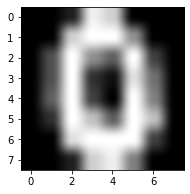

In [176]:
plt.figure(figsize=(3, 3))
plt.imshow(X[20].reshape(8, -1), interpolation='hanning', cmap='gray')

In [195]:
dig = TSNE(n_iter=2000).fit_transform(X)

In [121]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [127]:
np.random.seed(42)
colorlist=dict()
for i in np.unique(y):
    colorlist[i] =np.random.rand(3, )

In [128]:
colorlist

{0: array([0.37454012, 0.95071431, 0.73199394]),
 1: array([0.59865848, 0.15601864, 0.15599452]),
 2: array([0.05808361, 0.86617615, 0.60111501]),
 3: array([0.70807258, 0.02058449, 0.96990985]),
 4: array([0.83244264, 0.21233911, 0.18182497]),
 5: array([0.18340451, 0.30424224, 0.52475643]),
 6: array([0.43194502, 0.29122914, 0.61185289]),
 7: array([0.13949386, 0.29214465, 0.36636184]),
 8: array([0.45606998, 0.78517596, 0.19967378]),
 9: array([0.51423444, 0.59241457, 0.04645041])}

In [178]:
import seaborn as sns

In [181]:
palette = np.array(sns.color_palette("hls", 10))

In [182]:
palette

array([[0.86  , 0.3712, 0.34  ],
       [0.86  , 0.6832, 0.34  ],
       [0.7248, 0.86  , 0.34  ],
       [0.4128, 0.86  , 0.34  ],
       [0.34  , 0.86  , 0.5792],
       [0.34  , 0.8288, 0.86  ],
       [0.34  , 0.5168, 0.86  ],
       [0.4752, 0.34  , 0.86  ],
       [0.7872, 0.34  , 0.86  ],
       [0.86  , 0.34  , 0.6208]])

In [150]:
y.shape

(1797,)

In [151]:
y.astype(np.int)

array([0, 0, 0, ..., 9, 9, 9])

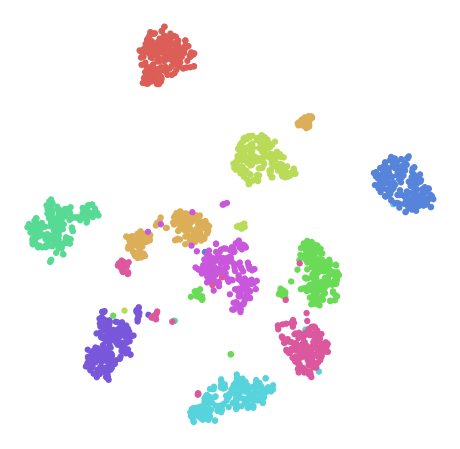

In [196]:
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(dig[:, 0], dig[:, 1], lw=0, s=40, c=palette[y.astype(np.int)])
ax.axis('off')
ax.axis('tight')
plt.show()

(-65.14748973846436, 65.0366231918335, -66.32433757781982, 84.2858434677124)

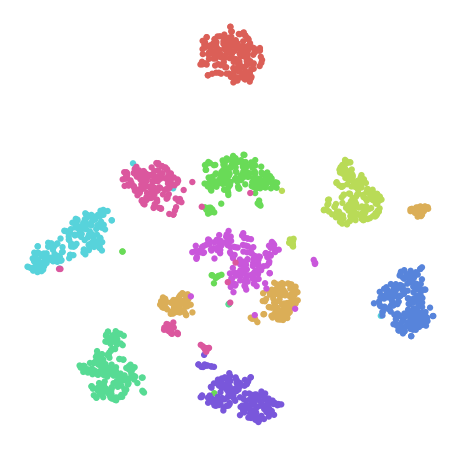

In [194]:
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(dig[:, 0], dig[:, 1], lw=0, s=40, c=palette[y.astype(np.int)])
ax.axis('off')
ax.axis('tight')
plt.show()

In [192]:
colorlist = np.array(sns.color_palette('hls', 10))

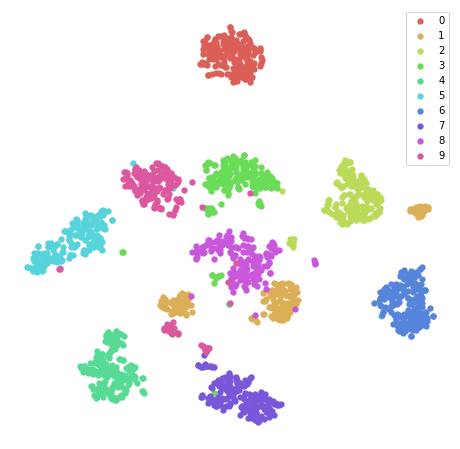

In [193]:
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
for i in np.unique(y):
    sc = ax.scatter(dig[y==i][:, 0], dig[y==i][:, 1], lw=0, s=40, color=colorlist[i], label=i)
    ax.legend()
    ax.axis('off')
    ax.axis('tight')

plt.show()

In [83]:
import matplotlib as mpl

In [84]:
N = 20

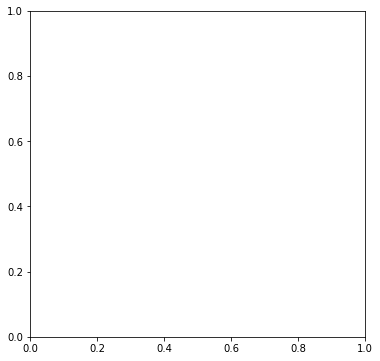

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

x = np.random.rand(1000)
y = np.random.rand(1000)
tag = np.random.randint(0,N,1000)

cmap = plt.cm.jet

cmaplist = [cmap(i) for i in range(cmap.N)]

cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)


In [98]:
cmap

## Preprocessing
First, grab only 'session_T' then divide eeg_data (X) into left and right hand   
In this early experiment subject 1 and 2 will be used as target while the rest as sources

In [47]:
ori_data[1]['X'].shape

(288, 22, 751)

In [50]:
# Only take data belonging to session_T, do this for all subjects
from copy import deepcopy
all_data = deepcopy(ori_data)

for subj in range(1, 10):
    idx = all_data[subj]['meta'][all_data[subj]['meta'].session == 'session_T'].index.values
    all_data[subj]['X'] = all_data[subj]['X'][idx]
    all_data[subj]['X'] = all_data[subj]['X'].reshape(all_data[subj]['X'].shape[0], all_data[subj]['X'].shape[1], all_data[subj]['X'].shape[2])
    all_data[subj]['y'] = all_data[subj]['y'][idx]
    
    # Divide them into left and right hand
    all_data[subj]['left_hand'] = all_data[subj]['X'][all_data[subj]['y'] == 'left_hand']
    all_data[subj]['right_hand'] = all_data[subj]['X'][all_data[subj]['y'] == 'right_hand']    

In [51]:
all_data[1]['X'].shape

(144, 22, 751)

In [117]:
all_data[1]['left_hand'][0][0][:50]

array([ -9.14191696, -11.40696936, -11.21258134,  -8.68376597,
        -4.59912832,  -0.07569719,   3.82230888,   6.37972667,
         7.34021711,   6.84364185,   5.27707906,   3.13170091,
         0.90441751,  -0.97811483,  -2.24226967,  -2.83512959,
        -2.91667921,  -2.75111618,  -2.55369506,  -2.39425553,
        -2.21951115,  -1.96513015,  -1.65853343,  -1.41987996,
        -1.3510833 ,  -1.3986444 ,  -1.30718873,  -0.72060542,
         0.61540869,   2.66583416,   5.04424169,   7.11533515,
         8.21400666,   7.88211124,   6.03172741,   2.98828778,
        -0.58888536,  -3.88415456,  -6.15702562,  -6.96137681,
        -6.27615009,  -4.49536536,  -2.28072811,  -0.33397538,
         0.82926733,   1.02836715,   0.4405955 ,  -0.5073915 ,
        -1.33304814,  -1.69128295])

In [113]:
fs = 250
mi_dur = 5

left_hand = []
for i in left_pos:
    print(i)
    left = X1['s'][i+int(fs*0.5): i + int(fs*3.5)]
    left_hand.append(left.T)
    
left_hand = np.array(left_hand)
#     right_hand = X1['s'][right_pos]

98242
100250
112163
114058
116030
124069
126135
130237
140283
154531
168776
186876
189204
191207
197085
201113
208998
214809
229142
239079
245162
251366
261676
283711
289960
297948
299998
313611
321841
333953
346094
348201
354427
364371
376373
380546
384877
386795
398764
402668
404563
430788
442929
447128
451262
455346
459281
469374
481712
489701
491618
505314
529584
537693
541871
546054
548097
550161
552181
572157
576544
600205
622505
626419
632502
636599
642889
646996
654876
663044
666878
671051


In [119]:
left_hand[0][0][:50]

array([-19.48242188, -16.65039062, -10.79101562, -15.0390625 ,
       -15.57617188, -16.25976562, -14.01367188, -16.89453125,
       -11.71875   , -11.08398438,  -3.36914062,  -5.90820312,
         0.43945312,   5.51757812,   5.2734375 ,   4.78515625,
         4.93164062,   9.27734375,   3.95507812,   4.44335938,
        -6.15234375,  -9.08203125,  -9.27734375, -13.96484375,
       -17.48046875, -18.75      , -24.95117188, -23.6328125 ,
       -24.95117188, -23.73046875, -22.265625  , -20.65429688,
       -22.11914062, -28.90625   , -26.41601562, -21.82617188,
       -28.27148438, -24.4140625 , -17.578125  , -17.52929688,
       -14.69726562,  -7.37304688,  -2.5390625 ,  -3.515625  ,
        -6.93359375,  -8.69140625,  -7.95898438,  -2.24609375,
        -6.00585938,  -4.93164062])

In [53]:
# Sanity check
# trial_no = 60
# assert np.all(all_data[1]['X'][trial_no][0].shape == ori_data[1]['X'][trial_no].shape)
# assert np.all(all_data[1]['X'][trial_no][0] == ori_data[1]['X'][trial_no])

In [18]:
# Currently label is still in string format change this to integer
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(all_data[1]['y'])

for i in all_data.keys():
    print('For subject:', i)
    print(all_data[i]['y'][:5])
    
    # Transform all label
    all_data[i]['y'] = enc.transform(all_data[i]['y'])
    
    print(all_data[i]['y'][:5])
    print('')

For subject: 1
['right_hand' 'left_hand' 'left_hand' 'right_hand' 'right_hand']
[1 0 0 1 1]

For subject: 2
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 3
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 4
['left_hand' 'left_hand' 'left_hand' 'right_hand' 'left_hand']
[0 0 0 1 0]

For subject: 5
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 6
['right_hand' 'right_hand' 'left_hand' 'right_hand' 'left_hand']
[1 1 0 1 0]

For subject: 7
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 8
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 9
['right_hand' 'right_hand' 'left_hand' 'right_hand' 'left_hand']
[1 1 0 1 0]



In [ ]:
#

In [46]:
ori_data[1]['meta'].session == 'session_T'

0      session_T
1      session_T
2      session_T
3      session_T
4      session_T
         ...    
283    session_E
284    session_E
285    session_E
286    session_E
287    session_E
Name: session, Length: 288, dtype: object

In [39]:
# Check with the original data npz
for i in range(1, 2):
    X = np.load('../../datasets/BCICIV2a/A{:02d}T.npz'.format(i))
    

In [42]:
X.files

['s', 'etyp', 'epos', 'edur', 'artifacts']